
# Rank filters

Rank filters are non-linear filters using local gray-level ordering to
compute the filtered value. This ensemble of filters share a common base:
the local gray-level histogram is computed on the neighborhood of a pixel
(defined by a 2D structuring element). If the filtered value is taken as the
middle value of the histogram, we get the classical median filter.

Rank filters can be used for several purposes, such as:

* image quality enhancement,
  e.g., image smoothing, sharpening

* image pre-processing,
  e.g., noise reduction, contrast enhancement

* feature extraction,
  e.g., border detection, isolated point detection

* image post-processing,
  e.g., small object removal, object grouping, contour smoothing

Some well-known filters (e.g., morphological dilation and morphological
erosion) are specific cases of rank filters [1]_.

In this example, we will see how to filter a gray-level image using some of the
linear and non-linear filters available in skimage. We use the ``camera`` image
from `skimage.data` for all comparisons.

.. [1] Pierre Soille, On morphological operators based on rank filters, Pattern
       Recognition 35 (2002) 527-535, :DOI:`10.1016/S0031-3203(01)00047-4`


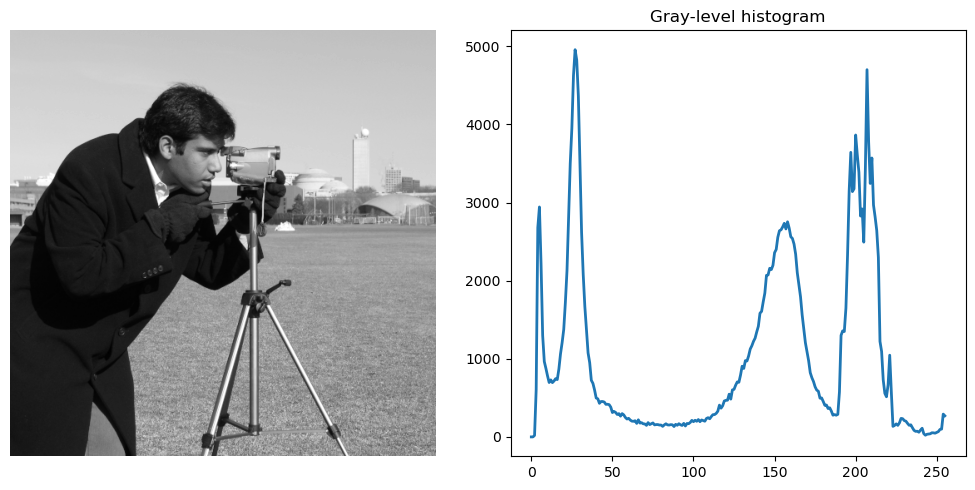

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.util import img_as_ubyte
from skimage import data
from skimage.exposure import histogram

noisy_image = img_as_ubyte(data.camera())
hist, hist_centers = histogram(noisy_image)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(noisy_image, cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].plot(hist_centers, hist, lw=2)
ax[1].set_title('Gray-level histogram')

plt.tight_layout()

## Noise removal

Some noise is added to the image: 1% of pixels are randomly set to 255, 1%
are randomly set to 0. The **median** filter is applied to remove the
noise.



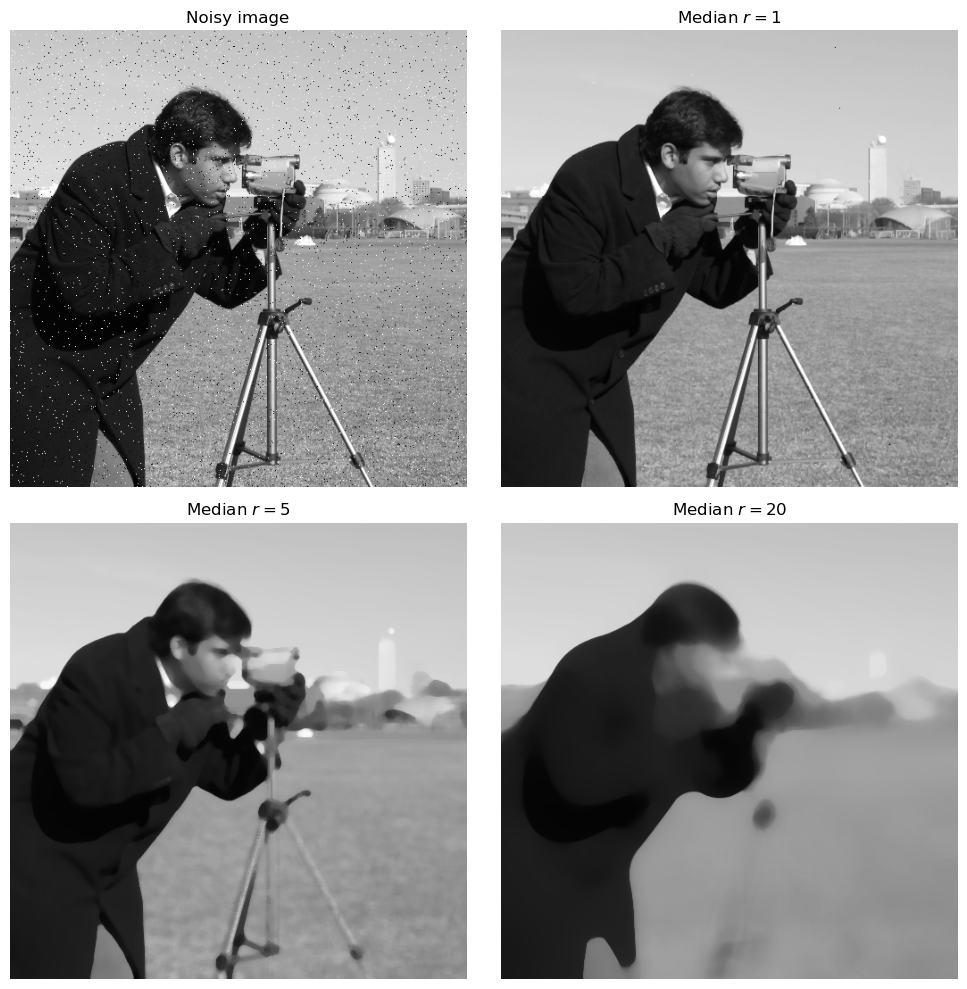

In [2]:
from skimage.filters.rank import median
from skimage.morphology import disk, ball

rng = np.random.default_rng()
noise = rng.random(noisy_image.shape)
noisy_image = img_as_ubyte(data.camera())
noisy_image[noise > 0.99] = 255
noisy_image[noise < 0.01] = 0

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(noisy_image, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title('Noisy image')

ax[1].imshow(median(noisy_image, disk(1)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('Median $r=1$')

ax[2].imshow(median(noisy_image, disk(5)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[2].set_title('Median $r=5$')

ax[3].imshow(median(noisy_image, disk(20)), vmin=0, vmax=255, cmap=plt.cm.gray)
ax[3].set_title('Median $r=20$')

for a in ax:
    a.axis('off')

plt.tight_layout()

The added noise is efficiently removed, as the image defaults are small (1-\
pixel wide), a small filter radius is sufficient. As the radius
increases, objects with bigger sizes get filtered as well, such as the
camera tripod. The median filter is often used for noise removal because it
preserves borders. For example, consider noise which is located only on a
few pixels in the entire image, as is the case with salt-and-pepper noise
[2]_: the median filter will ignore the noisy pixels, for they will appear
as outliers; thus, it will not change significantly the median of a group of
local pixels, in contrast to what a moving average filter would do.

.. [2] https://en.wikipedia.org/wiki/Salt-and-pepper_noise

## Image smoothing

The example hereunder shows how a local **mean** filter smooths the camera
man image.



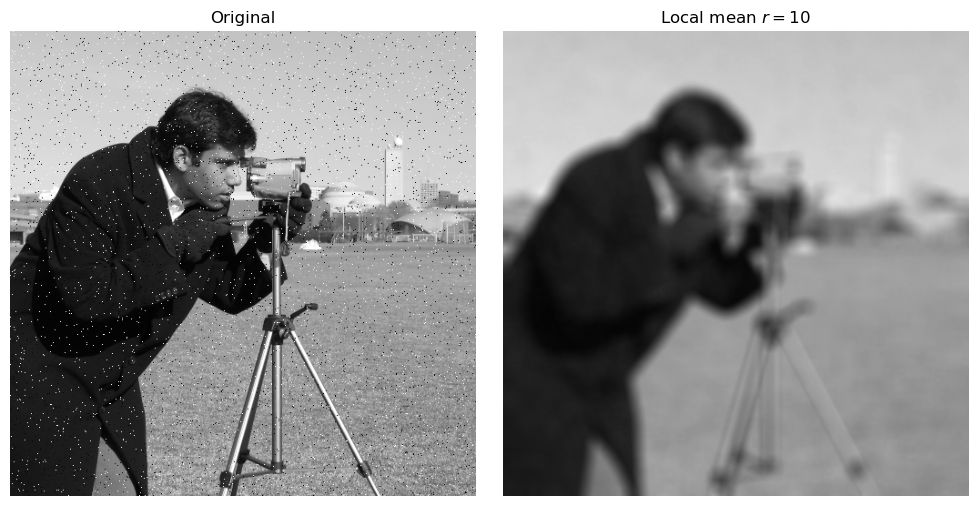

In [3]:
from skimage.filters.rank import mean

loc_mean = mean(noisy_image, disk(10))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].imshow(noisy_image, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(loc_mean, vmin=0, vmax=255, cmap=plt.cm.gray)
ax[1].set_title('Local mean $r=10$')

for a in ax:
    a.axis('off')

plt.tight_layout()

One may be interested in smoothing an image while preserving important
borders (median filters already achieved this). Here, we use the
**bilateral** filter that restricts the local neighborhood to pixels with
gray levels similar to the central one.

<div class="alert alert-info"><h4>Note</h4><p>A different implementation is available for color images in
    :func:`skimage.restoration.denoise_bilateral`.</p></div>



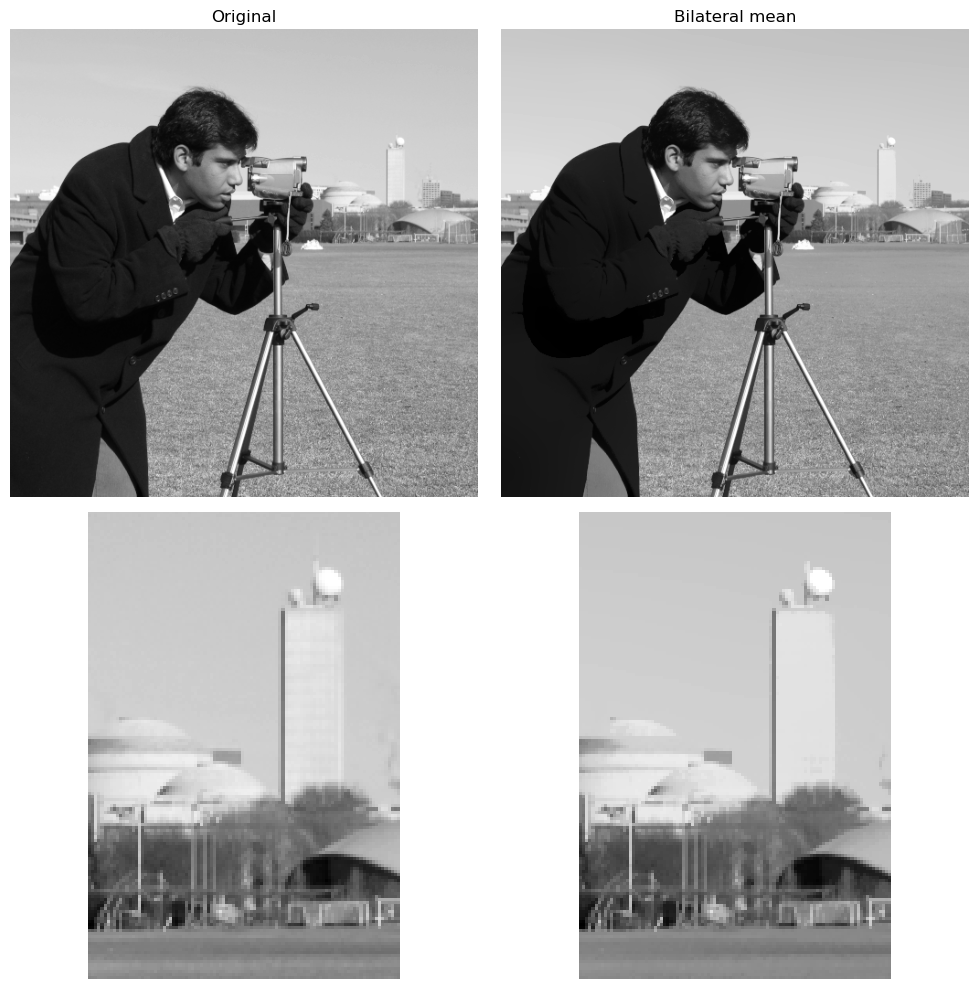

In [4]:
from skimage.filters.rank import mean_bilateral

noisy_image = img_as_ubyte(data.camera())

bilat = mean_bilateral(noisy_image.astype(np.uint16), disk(20), s0=10, s1=10)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex='row', sharey='row')
ax = axes.ravel()

ax[0].imshow(noisy_image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(bilat, cmap=plt.cm.gray)
ax[1].set_title('Bilateral mean')

ax[2].imshow(noisy_image[100:250, 350:450], cmap=plt.cm.gray)

ax[3].imshow(bilat[100:250, 350:450], cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

One can see that the large continuous part of the image (e.g. sky) is
smoothed whereas other details are preserved.

## Contrast enhancement

We compare here how the global histogram equalization is applied locally.

The equalized image [3]_ has a roughly linear cumulative distribution
function for each pixel neighborhood. The local version [4]_ of
histogram equalization emphasizes every local gray-level variation.

.. [3] https://en.wikipedia.org/wiki/Histogram_equalization
.. [4] https://en.wikipedia.org/wiki/Adaptive_histogram_equalization



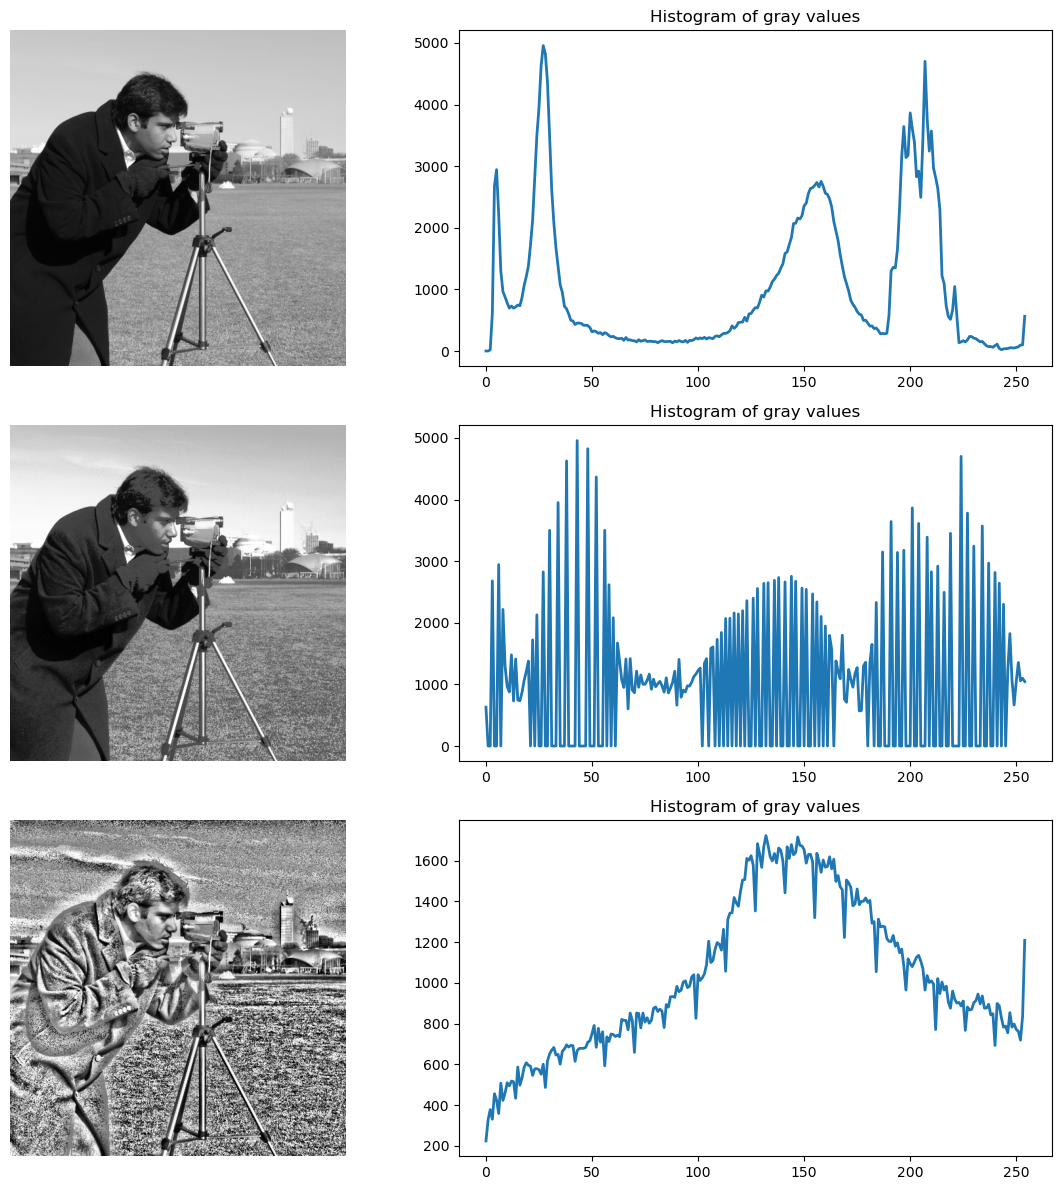

In [5]:
from skimage import exposure
from skimage.filters import rank

noisy_image = img_as_ubyte(data.camera())

# equalize globally and locally
glob = exposure.equalize_hist(noisy_image) * 255
loc = rank.equalize(noisy_image, disk(20))

# extract histogram for each image
hist = np.histogram(noisy_image, bins=np.arange(0, 256))
glob_hist = np.histogram(glob, bins=np.arange(0, 256))
loc_hist = np.histogram(loc, bins=np.arange(0, 256))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
ax = axes.ravel()

ax[0].imshow(noisy_image, cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].plot(hist[1][:-1], hist[0], lw=2)
ax[1].set_title('Histogram of gray values')

ax[2].imshow(glob, cmap=plt.cm.gray)
ax[2].axis('off')

ax[3].plot(glob_hist[1][:-1], glob_hist[0], lw=2)
ax[3].set_title('Histogram of gray values')

ax[4].imshow(loc, cmap=plt.cm.gray)
ax[4].axis('off')

ax[5].plot(loc_hist[1][:-1], loc_hist[0], lw=2)
ax[5].set_title('Histogram of gray values')

plt.tight_layout()

Another way to maximize the number of gray-levels used for an image is to
apply a local auto-leveling, i.e. the gray-value of a pixel is
proportionally remapped between local minimum and local maximum.

The following example shows how local auto-level enhances the camara man
picture.



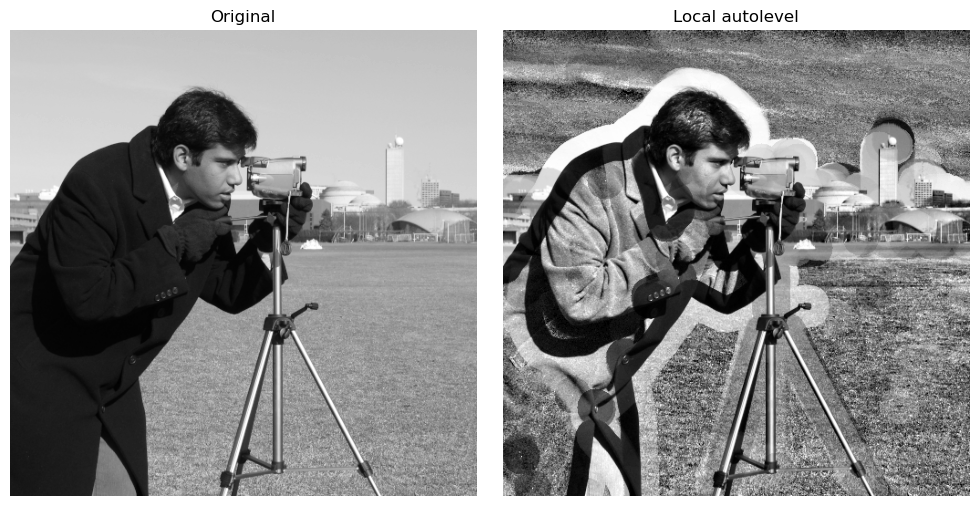

In [6]:
from skimage.filters.rank import autolevel

noisy_image = img_as_ubyte(data.camera())

auto = autolevel(noisy_image.astype(np.uint16), disk(20))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].imshow(noisy_image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(auto, cmap=plt.cm.gray)
ax[1].set_title('Local autolevel')

for a in ax:
    a.axis('off')

plt.tight_layout()

This filter is very sensitive to local outliers. One can
moderate this using the percentile version of the auto-level filter
which uses given percentiles (one inferior, one superior) in place
of local minimum and maximum. The example below illustrates how the
percentile parameters influence the local auto-level result.



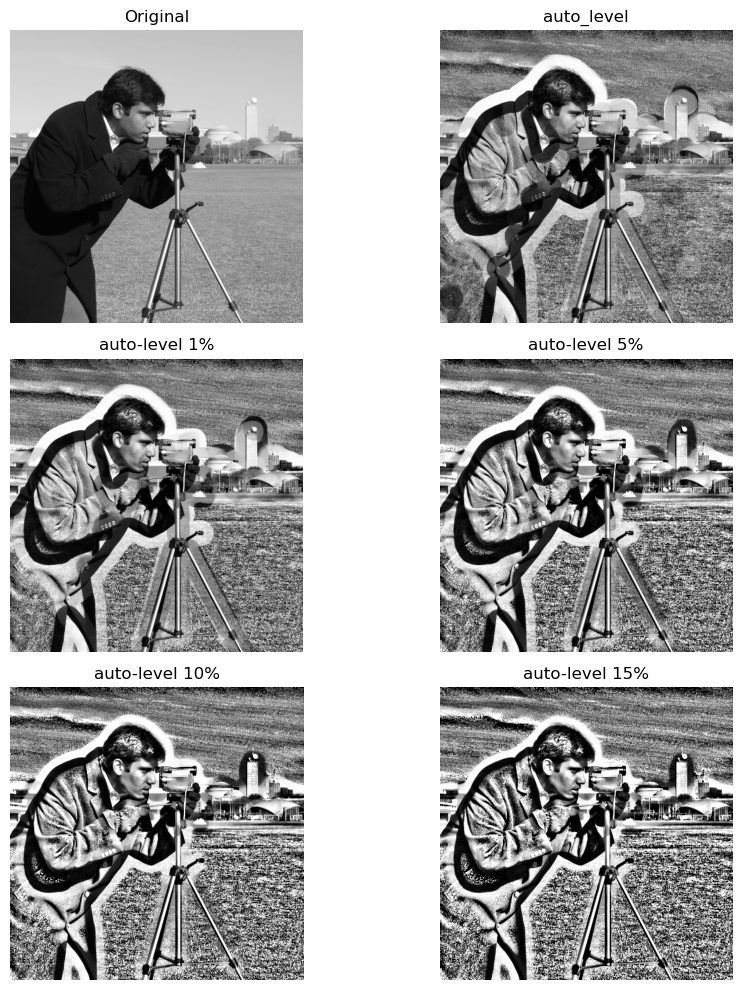

In [7]:
from skimage.filters.rank import autolevel_percentile

image = data.camera()

footprint = disk(20)
loc_autolevel = autolevel(image, footprint=footprint)
loc_perc_autolevel0 = autolevel_percentile(
    image, footprint=footprint, p0=.01, p1=.99
)
loc_perc_autolevel1 = autolevel_percentile(
    image, footprint=footprint, p0=.05, p1=.95
)
loc_perc_autolevel2 = autolevel_percentile(
    image, footprint=footprint, p0=.1, p1=.9
)
loc_perc_autolevel3 = autolevel_percentile(
    image, footprint=footprint, p0=.15, p1=.85
)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

title_list = ['Original',
              'auto_level',
              'auto-level 1%',
              'auto-level 5%',
              'auto-level 10%',
              'auto-level 15%']
image_list = [image,
              loc_autolevel,
              loc_perc_autolevel0,
              loc_perc_autolevel1,
              loc_perc_autolevel2,
              loc_perc_autolevel3]

for i in range(0, len(image_list)):
    ax[i].imshow(image_list[i], cmap=plt.cm.gray, vmin=0, vmax=255)
    ax[i].set_title(title_list[i])
    ax[i].axis('off')

plt.tight_layout()

The morphological contrast enhancement filter replaces the central pixel by
the local maximum if the original pixel value is closest to local maximum,
otherwise by the minimum local.



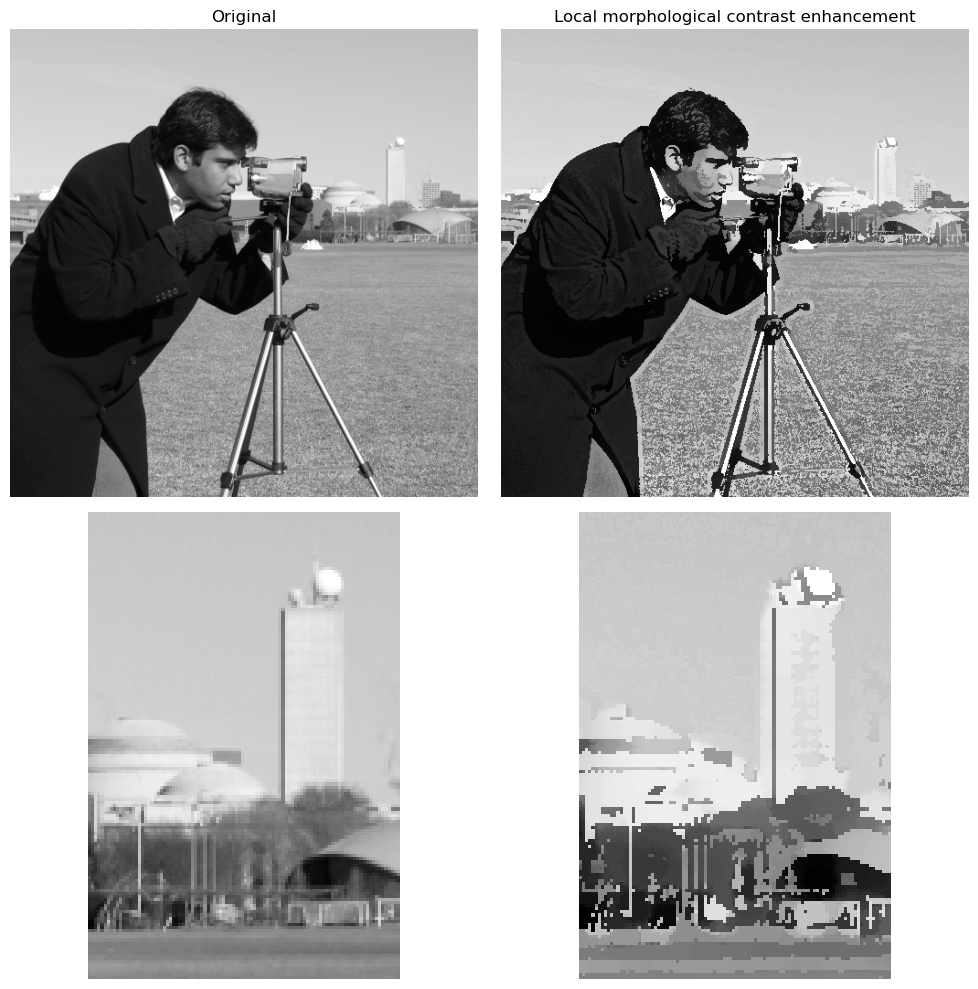

In [8]:
from skimage.filters.rank import enhance_contrast

noisy_image = img_as_ubyte(data.camera())

enh = enhance_contrast(noisy_image, disk(5))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex='row', sharey='row')
ax = axes.ravel()

ax[0].imshow(noisy_image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(enh, cmap=plt.cm.gray)
ax[1].set_title('Local morphological contrast enhancement')

ax[2].imshow(noisy_image[100:250, 350:450], cmap=plt.cm.gray)

ax[3].imshow(enh[100:250, 350:450], cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

The percentile version of the local morphological contrast enhancement uses
percentile *p0* and *p1* instead of the local minimum and maximum.



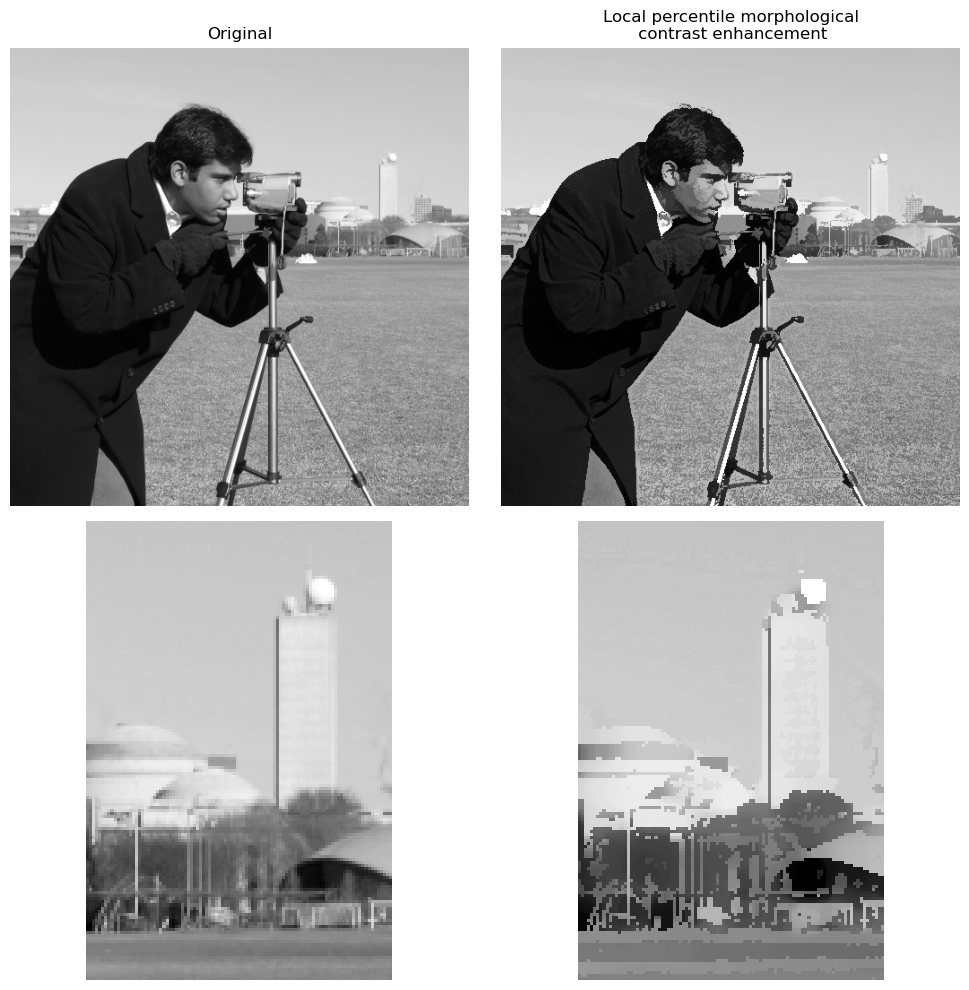

In [9]:
from skimage.filters.rank import enhance_contrast_percentile

noisy_image = img_as_ubyte(data.camera())

penh = enhance_contrast_percentile(noisy_image, disk(5), p0=.1, p1=.9)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex='row', sharey='row')
ax = axes.ravel()

ax[0].imshow(noisy_image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(penh, cmap=plt.cm.gray)
ax[1].set_title('Local percentile morphological\n contrast enhancement')

ax[2].imshow(noisy_image[100:250, 350:450], cmap=plt.cm.gray)

ax[3].imshow(penh[100:250, 350:450], cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Image threshold

The Otsu threshold method [5]_ can be applied locally using the local gray-\
level distribution. In the example below, for each pixel, an "optimal"
threshold is determined by maximizing the variance between two classes of
pixels of the local neighborhood defined by a structuring element.

These algorithms can be used on both 2D and 3D images.

The example compares local thresholding with global thresholding, which is
provided by :func:`skimage.filters.threshold_otsu`. Note that the former is
much slower than the latter.

.. [5] https://en.wikipedia.org/wiki/Otsu's_method



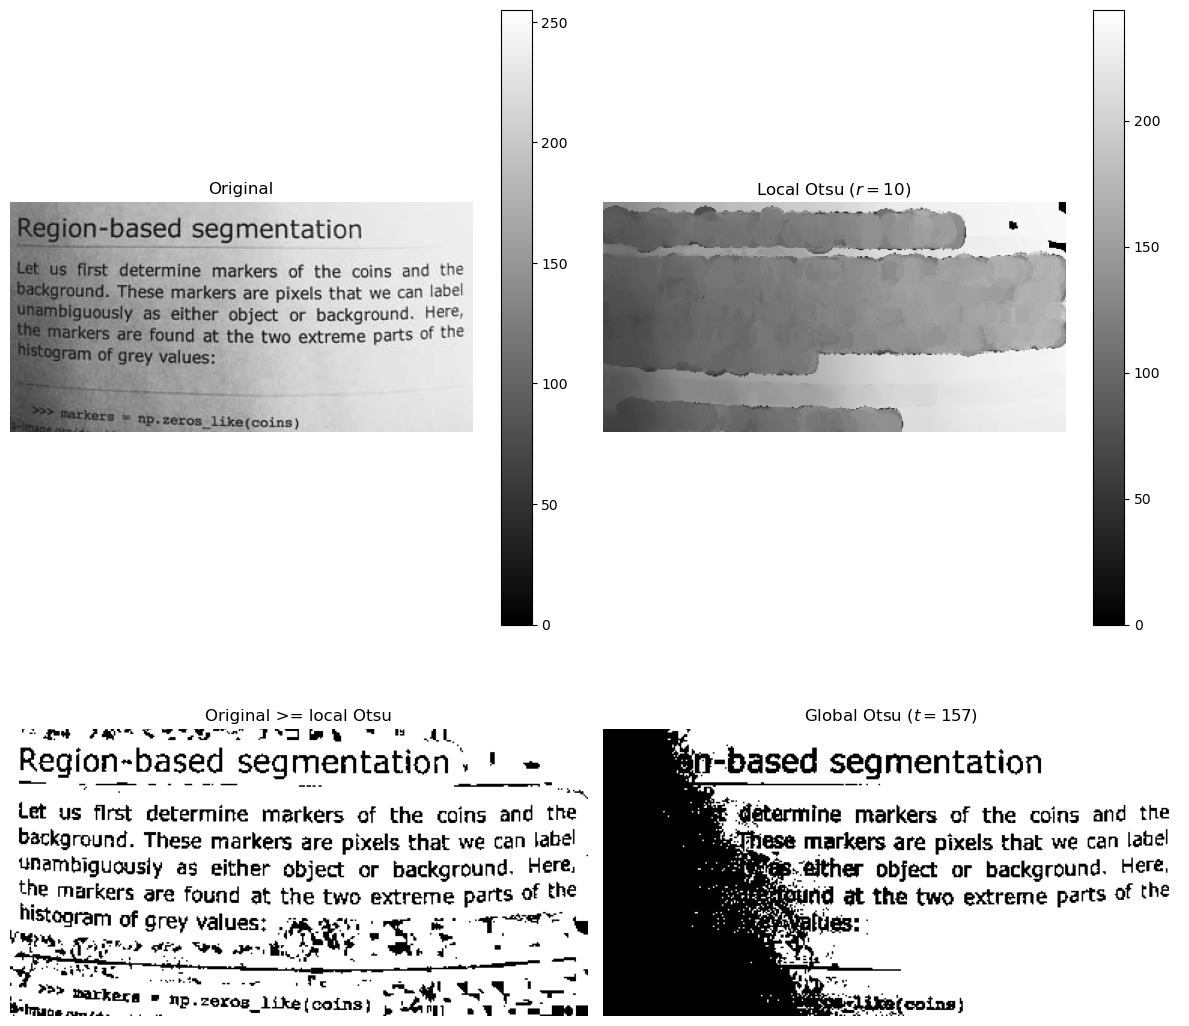

In [10]:
from skimage.filters.rank import otsu
from skimage.filters import threshold_otsu
from skimage import exposure

p8 = data.page()

radius = 10
footprint = disk(radius)

# t_loc_otsu is an image
t_loc_otsu = otsu(p8, footprint)
loc_otsu = p8 >= t_loc_otsu

# t_glob_otsu is a scalar
t_glob_otsu = threshold_otsu(p8)
glob_otsu = p8 >= t_glob_otsu

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

fig.colorbar(ax[0].imshow(p8, cmap=plt.cm.gray), ax=ax[0])
ax[0].set_title('Original')

fig.colorbar(ax[1].imshow(t_loc_otsu, cmap=plt.cm.gray), ax=ax[1])
ax[1].set_title(f'Local Otsu ($r={radius}$)')

ax[2].imshow(p8 >= t_loc_otsu, cmap=plt.cm.gray)
ax[2].set_title('Original >= local Otsu')

ax[3].imshow(glob_otsu, cmap=plt.cm.gray)
ax[3].set_title(f'Global Otsu ($t={t_glob_otsu}$)')

for a in ax:
    a.axis('off')

plt.tight_layout()

The example below performs the same comparison, using a 3D image this time.



/home/bjpcjp/.local/lib/python3.11/site-packages/skimage/filters/rank/generic.py:282: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  image, footprint, out, mask, n_bins = _handle_input_3D(


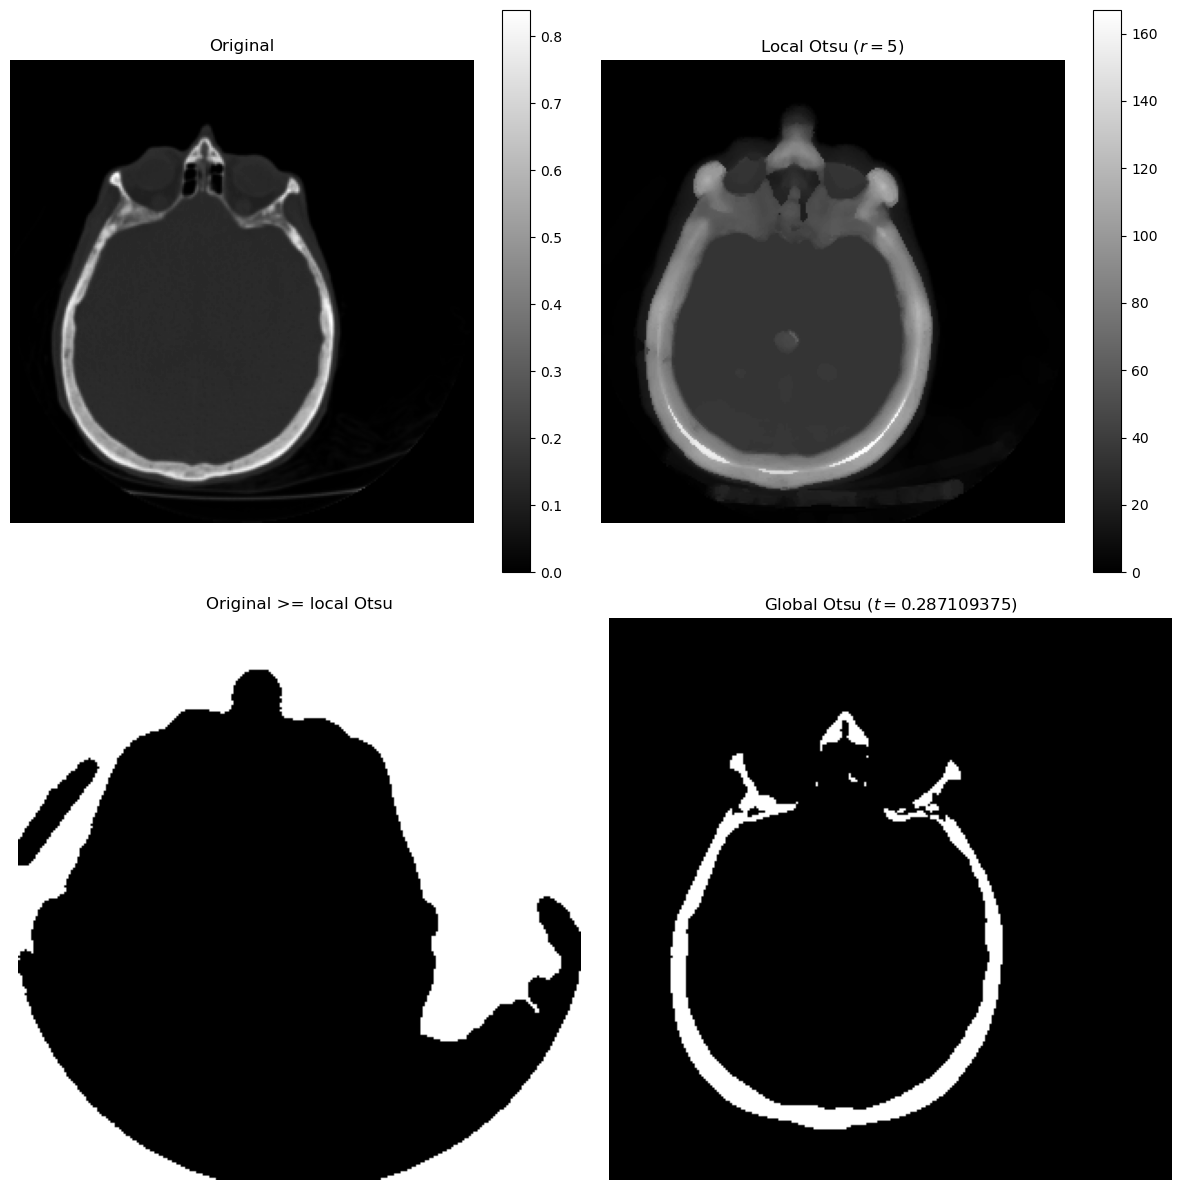

In [11]:
brain = exposure.rescale_intensity(data.brain().astype(float))

radius = 5
neighborhood = ball(radius)

# t_loc_otsu is an image
t_loc_otsu = rank.otsu(brain, neighborhood)
loc_otsu = brain >= t_loc_otsu

# t_glob_otsu is a scalar
t_glob_otsu = threshold_otsu(brain)
glob_otsu = brain >= t_glob_otsu

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12),
                         sharex=True, sharey=True)
ax = axes.ravel()

slice_index = 3

fig.colorbar(ax[0].imshow(brain[slice_index], cmap=plt.cm.gray), ax=ax[0])
ax[0].set_title('Original')

fig.colorbar(ax[1].imshow(t_loc_otsu[slice_index], cmap=plt.cm.gray), ax=ax[1])
ax[1].set_title(f'Local Otsu ($r={radius}$)')

ax[2].imshow(brain[slice_index] >= t_loc_otsu[slice_index], cmap=plt.cm.gray)
ax[2].set_title('Original >= local Otsu')

ax[3].imshow(glob_otsu[slice_index], cmap=plt.cm.gray)
ax[3].set_title(f'Global Otsu ($t={t_glob_otsu}$)')

for a in ax:
    a.axis('off')

fig.tight_layout()

The following example shows how local Otsu thresholding handles a global
level shift applied to a synthetic image.



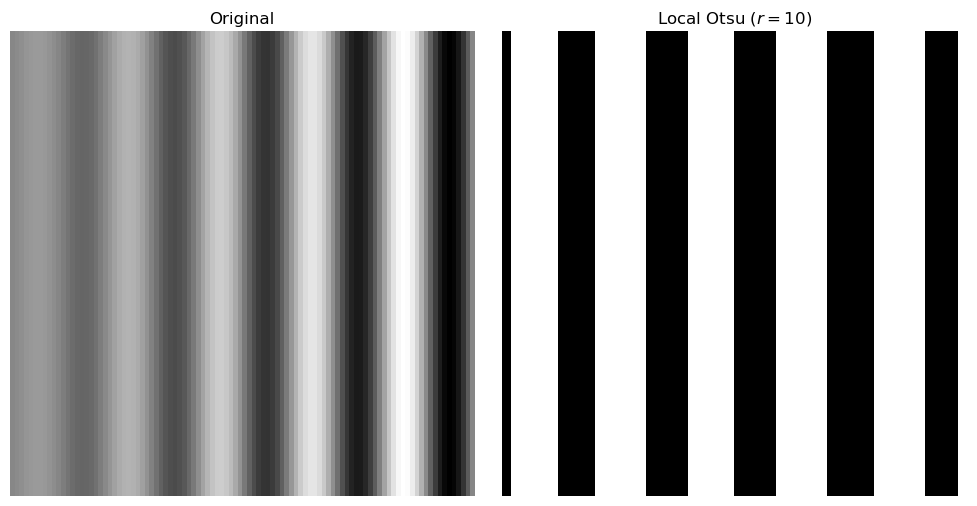

In [12]:
n = 100
theta = np.linspace(0, 10 * np.pi, n)
x = np.sin(theta)
m = (np.tile(x, (n, 1)) * np.linspace(0.1, 1, n) * 128 + 128).astype(np.uint8)

radius = 10
t = rank.otsu(m, disk(radius))

fig, ax = plt.subplots(ncols=2, figsize=(10, 5),
                       sharex=True, sharey=True)

ax[0].imshow(m, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(m >= t, cmap=plt.cm.gray)
ax[1].set_title(f'Local Otsu ($r={radius}$)')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Image morphology

Local maximum and local minimum are the base operators for gray-level
morphology.

Here is an example of the classical morphological gray-level filters:
opening, closing and morphological gradient.



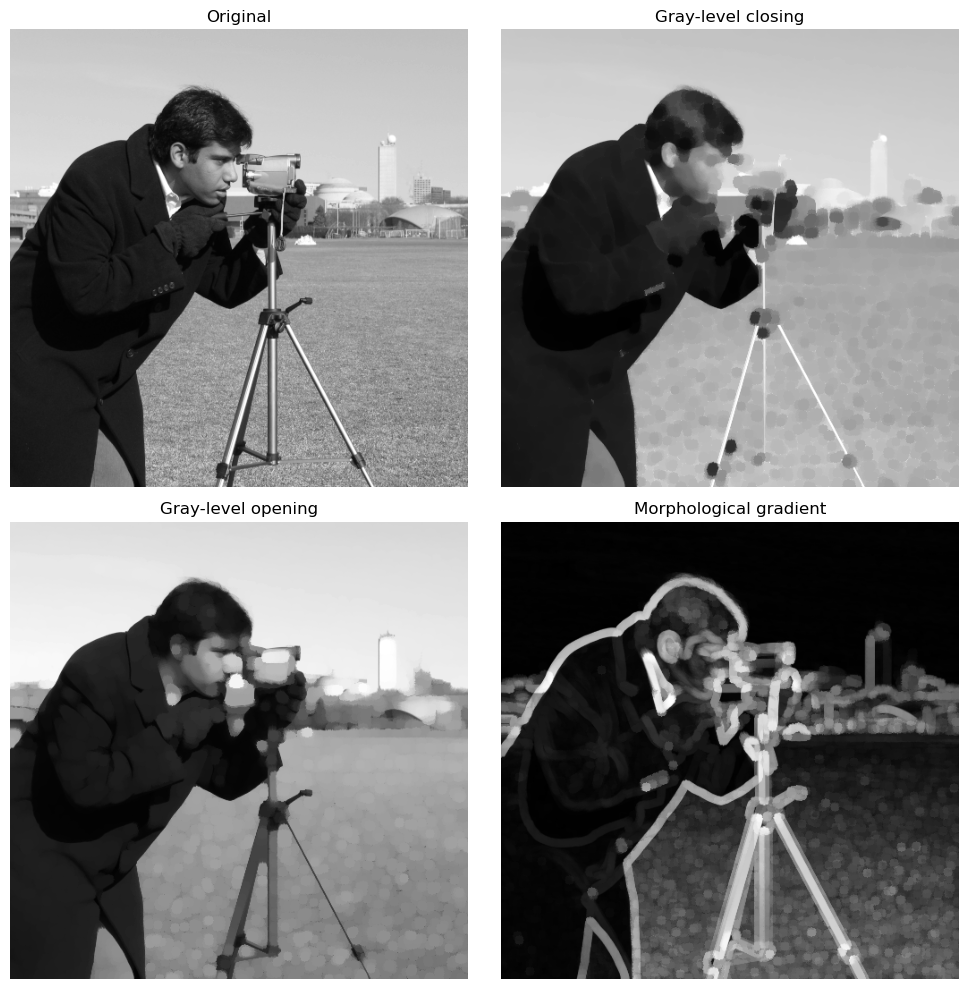

In [13]:
from skimage.filters.rank import maximum, minimum, gradient

noisy_image = img_as_ubyte(data.camera())

opening = maximum(minimum(noisy_image, disk(5)), disk(5))
closing = minimum(maximum(noisy_image, disk(5)), disk(5))
grad = gradient(noisy_image, disk(5))

# display results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(noisy_image, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(closing, cmap=plt.cm.gray)
ax[1].set_title('Gray-level closing')

ax[2].imshow(opening, cmap=plt.cm.gray)
ax[2].set_title('Gray-level opening')

ax[3].imshow(grad, cmap=plt.cm.gray)
ax[3].set_title('Morphological gradient')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Feature extraction

Local histograms can be exploited to compute local entropy, which is
related to the local image complexity. Entropy is computed using base 2
logarithm, i.e., the filter returns the minimum number of bits needed to
encode local gray-level distribution.

:func:`skimage.filters.rank.entropy` returns the local entropy on a given
structuring element. The following example applies this filter
on 8- and 16-bit images.

<div class="alert alert-info"><h4>Note</h4><p>To better use the available image bit, the function returns 10x entropy
    for 8-bit images and 1000x entropy for 16-bit images.</p></div>



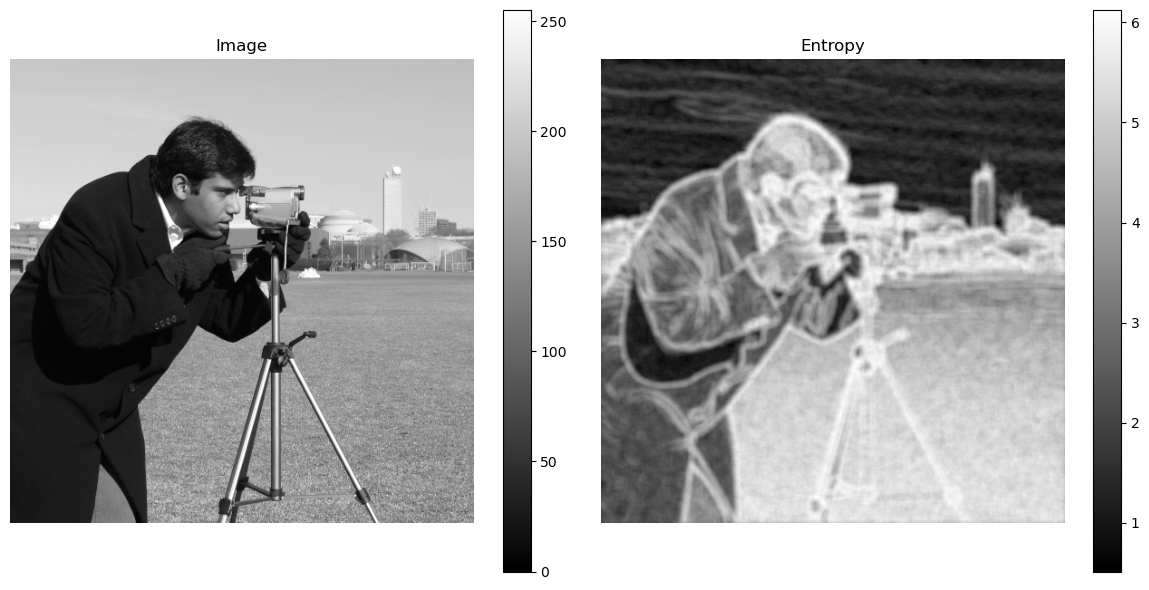

In [14]:
from skimage import data
from skimage.filters.rank import entropy
from skimage.morphology import disk
import numpy as np
import matplotlib.pyplot as plt

image = data.camera()

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)

fig.colorbar(ax[0].imshow(image, cmap=plt.cm.gray), ax=ax[0])
ax[0].set_title('Image')

fig.colorbar(ax[1].imshow(entropy(image, disk(5)), cmap=plt.cm.gray), ax=ax[1])
ax[1].set_title('Entropy')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Implementation

The central part of the `skimage.filters.rank` filters is built on a sliding
window that updates the local gray-level histogram. This approach limits the
algorithm complexity to O(n) where n is the number of image pixels. The
complexity is also limited with respect to the structuring element size.

In the following, we compare the performance of different implementations
available in `skimage`.



In [15]:
from time import time

from scipy.ndimage import percentile_filter
from skimage.morphology import dilation
from skimage.filters.rank import median, maximum


def exec_and_timeit(func):
    """Decorator that returns both function results and execution time."""
    def wrapper(*arg):
        t1 = time()
        res = func(*arg)
        t2 = time()
        ms = (t2 - t1) * 1000.0
        return (res, ms)
    return wrapper


@exec_and_timeit
def cr_med(image, footprint):
    return median(image=image, footprint=footprint)


@exec_and_timeit
def cr_max(image, footprint):
    return maximum(image=image, footprint=footprint)


@exec_and_timeit
def cm_dil(image, footprint):
    return dilation(image=image, footprint=footprint)


@exec_and_timeit
def ndi_med(image, n):
    return percentile_filter(image, 50, size=n * 2 - 1)

Comparison between

* `skimage.filters.rank.maximum`
* `skimage.morphology.dilation`

on increasing structuring element size:



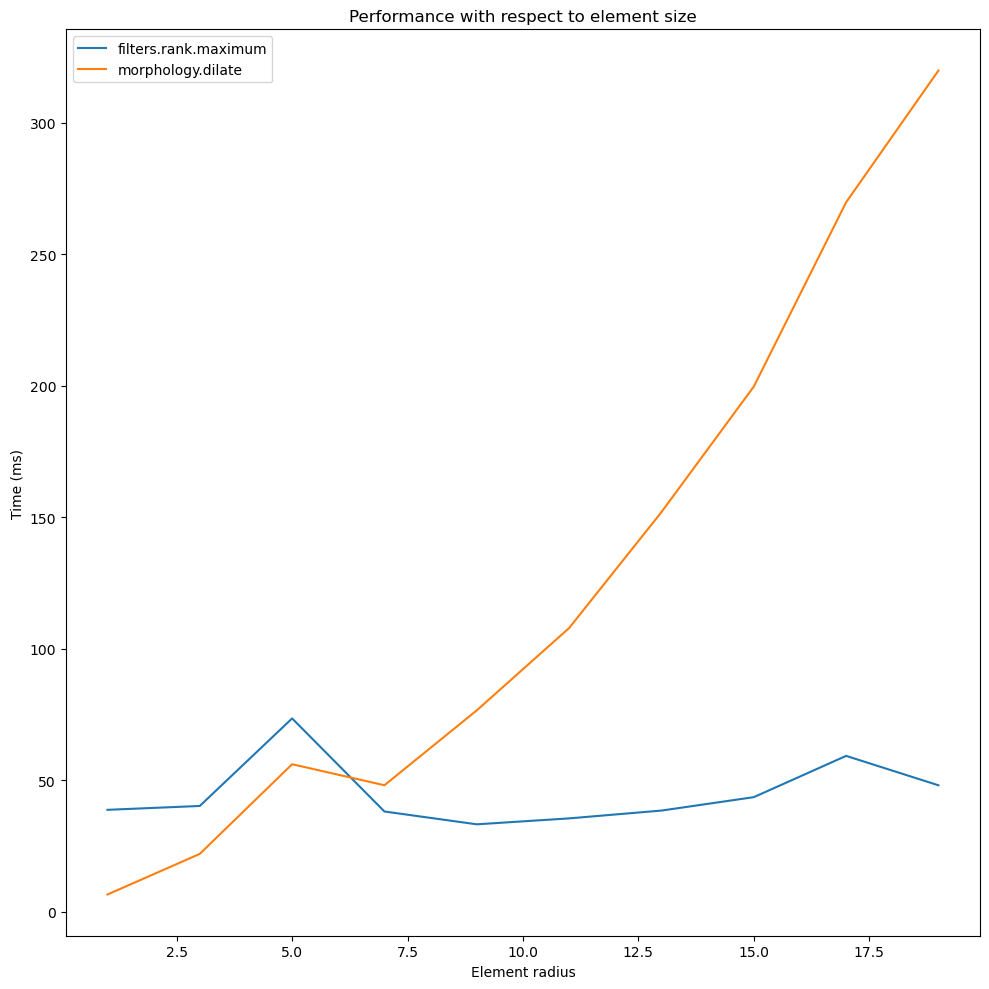

In [16]:
a = data.camera()

rec = []
e_range = range(1, 20, 2)
for r in e_range:
    elem = disk(r + 1)
    rc, ms_rc = cr_max(a, elem)
    rcm, ms_rcm = cm_dil(a, elem)
    rec.append((ms_rc, ms_rcm))

rec = np.asarray(rec)

fig, ax = plt.subplots(figsize=(10, 10), sharey=True)
ax.set_title('Performance with respect to element size')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Element radius')
ax.plot(e_range, rec)
ax.legend(['filters.rank.maximum', 'morphology.dilate'])

plt.tight_layout()

and increasing image size:



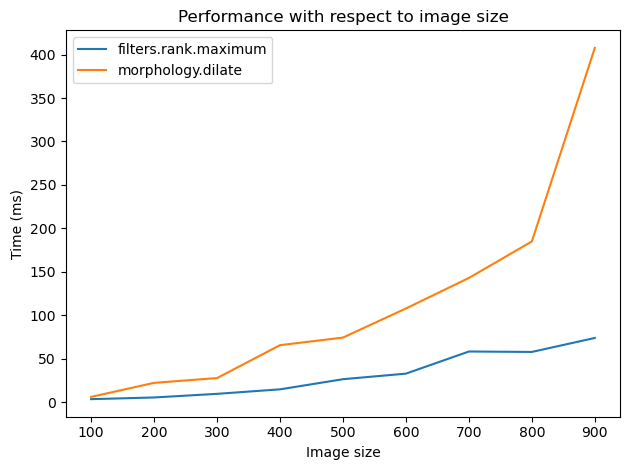

In [17]:
r = 9
elem = disk(r + 1)

rec = []
s_range = range(100, 1000, 100)
for s in s_range:
    a = (rng.random((s, s)) * 256).astype(np.uint8)
    (rc, ms_rc) = cr_max(a, elem)
    (rcm, ms_rcm) = cm_dil(a, elem)
    rec.append((ms_rc, ms_rcm))

rec = np.asarray(rec)

fig, ax = plt.subplots()
ax.set_title('Performance with respect to image size')
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Image size')
ax.plot(s_range, rec)
ax.legend(['filters.rank.maximum', 'morphology.dilate'])

plt.tight_layout()

Comparison between:

* `skimage.filters.rank.median`
* `scipy.ndimage.percentile_filter`

on increasing structuring element size:



Text(0.5, 0, 'Element radius')

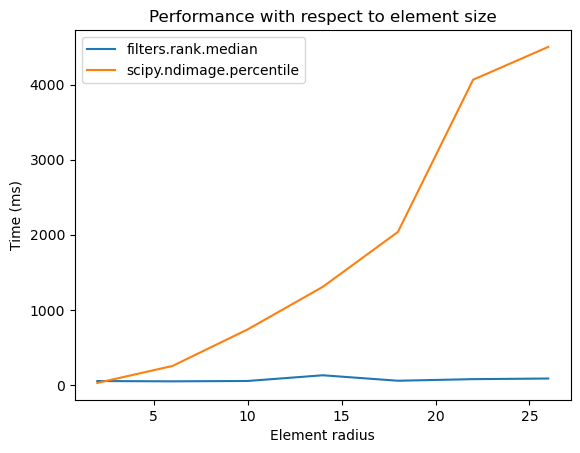

In [18]:
a = data.camera()

rec = []
e_range = range(2, 30, 4)
for r in e_range:
    elem = disk(r + 1)
    rc, ms_rc = cr_med(a, elem)
    rndi, ms_ndi = ndi_med(a, r)
    rec.append((ms_rc, ms_ndi))

rec = np.asarray(rec)

fig, ax = plt.subplots()
ax.set_title('Performance with respect to element size')
ax.plot(e_range, rec)
ax.legend(['filters.rank.median', 'scipy.ndimage.percentile'])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Element radius')

Comparison of outcome of the two methods:



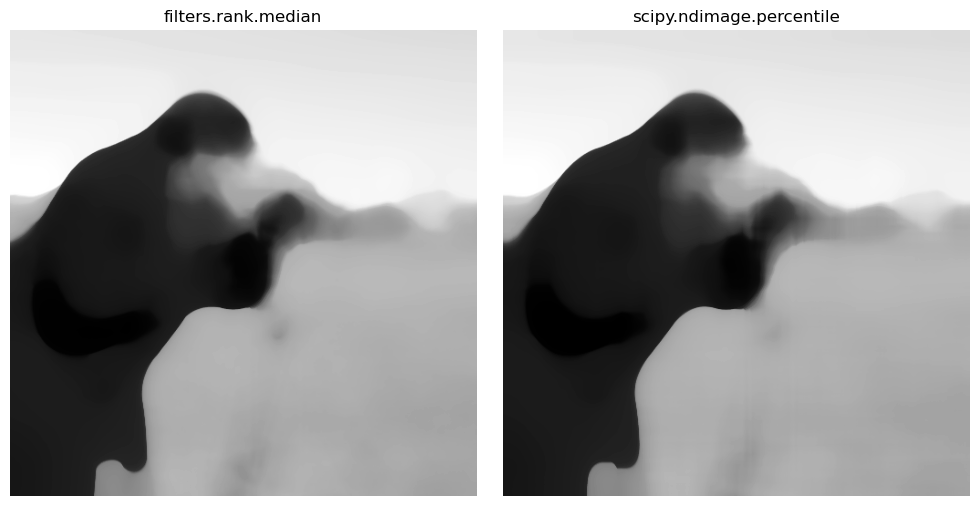

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

ax[0].set_title('filters.rank.median')
ax[0].imshow(rc, cmap=plt.cm.gray)

ax[1].set_title('scipy.ndimage.percentile')
ax[1].imshow(rndi, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

plt.tight_layout()

on increasing image size:



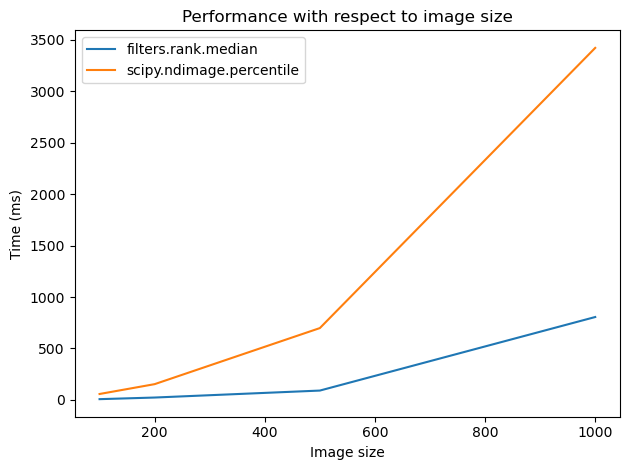

In [20]:
r = 9
elem = disk(r + 1)

rec = []
s_range = [100, 200, 500, 1000]
for s in s_range:
    a = (rng.random((s, s)) * 256).astype(np.uint8)
    (rc, ms_rc) = cr_med(a, elem)
    rndi, ms_ndi = ndi_med(a, r)
    rec.append((ms_rc, ms_ndi))

rec = np.asarray(rec)

fig, ax = plt.subplots()
ax.set_title('Performance with respect to image size')
ax.plot(s_range, rec)
ax.legend(['filters.rank.median', 'scipy.ndimage.percentile'])
ax.set_ylabel('Time (ms)')
ax.set_xlabel('Image size')

plt.tight_layout()

plt.show()